# Optimized LLM-driven Decision Making for Iterated Prisoner's Dilemma



This notebook implements an LLM-driven simulation of the Iterated Prisoner's Dilemma using OpenAI's API. 

The simulation features:

- Dynamic strategy generation using GPT-4

- Evolutionary agent selection

- Asynchronous execution for improved performance

- Detailed logging and visualization

## Setup and Imports

First, we'll import the necessary libraries and set up our OpenAI client.

In [4]:
#%% 
from openai import OpenAI, AsyncOpenAI
import os
import random
import pandas as pd
import json
import matplotlib.pyplot as plt
import datetime
from dotenv import load_dotenv
import asyncio
from typing import List, Tuple, Dict
import aiohttp
import sys

# Load environment variables and setup OpenAI client
load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key=api_key)
async_client = AsyncOpenAI(api_key=api_key)

# =============================================================================
# Comprehensive List of Prisoner's Dilemma Tactics with Explanations
# =============================================================================
PD_STRATEGIES = {
    "always_cooperate": "Always Cooperate: The agent always chooses to cooperate, regardless of the opponent's actions.",
    "always_defect": "Always Defect: The agent always chooses to defect, regardless of the opponent's actions.",
    "tit_for_tat": "Tit-for-Tat: The agent starts by cooperating, then mirrors the opponent's last move.",
    "grim_trigger": "Grim Trigger: The agent cooperates until the opponent defects once, then always defects thereafter.",
    "win_stay_lose_shift": "Win-Stay, Lose-Shift (Pavlov): The agent repeats its previous move if it resulted in a favorable payoff; otherwise, it switches.",
    "generous_tit_for_tat": "Generous Tit-for-Tat: Similar to Tit-for-Tat, but occasionally forgives a defection (influenced by the agent's cooperation bias) to encourage cooperation.",
    "suspicious_tit_for_tat": "Suspicious Tit-for-Tat: Starts with defection, then mirrors the opponent's last move, expecting defection from the opponent.",
    "random": "Random: The agent randomly selects between cooperation and defection.",
    "contrite_tit_for_tat": "Contrite Tit-for-Tat: Like Tit-for-Tat, but if the agent inadvertently defects, it 'apologizes' by cooperating in subsequent rounds."
}

## Agent Implementation

The EnhancedAgent class represents a player in the Prisoner's Dilemma game.

Each agent:

- Has a unique strategy matrix generated by GPT-4

- Maintains a history of interactions

- Makes decisions based on past interactions and current game state

In [5]:
#%% 
class EnhancedAgent:
    def __init__(self, name, model="gpt-4-turbo", 
                 strategy_tactic="tit_for_tat", 
                 cooperation_bias=0.5,      # Bias toward cooperation (0 to 1)
                 risk_aversion=0.5,         # Tendency to avoid risky moves (0 to 1)
                 game_theoretic_prior=None  # Additional prior parameters as a dict
                ):
        self.name = name
        self.model = model  # Track model architecture
        self.strategy_tactic = strategy_tactic  # Explicit tactic name (should be a key in PD_STRATEGIES)
        self.cooperation_bias = cooperation_bias
        self.risk_aversion = risk_aversion
        self.game_theoretic_prior = game_theoretic_prior if game_theoretic_prior is not None else {}
        
        self.total_score = 0
        self.history = []  # Each entry: (opponent_name, own_action, opp_action, payoff)
        self.strategy_matrix = None
        self.strategy_evolution = []  # Track strategy changes over generations
        self.cooperation_rate = 0.0
        self.reciprocity_index = 0.0  # Measure tit-for-tat behavior

    async def initialize(self):
        """Asynchronously initialize the agent's strategy matrix."""
        self.strategy_matrix = await self.generate_strategy_matrix()
        return self

    async def generate_strategy_matrix(self):
        prompt = """System: You are developing a novel strategy for the Iterated Prisoner's Dilemma. 
Create a unique approach that considers:
- Long-term relationship building
- Error correction mechanisms
- Adaptive response patterns
- Potential for both cooperation and defection

Format: JSON structure with:
{
    "strategy_rules": [list of conditional statements],
    "forgiveness_factor": 0-1,
    "retaliation_threshold": 0-1,
    "adaptability": 0-1,
    "rationale": "str"
}"""
        
        for _ in range(3):  # Retry up to 3 times
            try:
                response = await async_client.chat.completions.create(
                    model=self.model,
                    messages=[{"role": "system", "content": "You are a game theory expert creating novel IPD strategies. Respond ONLY with valid JSON."},
                              {"role": "user", "content": prompt}],
                    temperature=0.8,
                    response_format={"type": "json_object"},
                    max_tokens=300
                )
                json_str = response.choices[0].message.content.strip()
                # Basic JSON validation
                if not json_str.startswith('{') or not json_str.endswith('}'):
                    raise json.JSONDecodeError("Missing braces", json_str, 0)
                strategy = json.loads(json_str)
                # Validate required fields
                if all(k in strategy for k in ["strategy_rules", "forgiveness_factor", 
                                                 "retaliation_threshold", "adaptability"]):
                    return strategy
            except (json.JSONDecodeError, KeyError) as e:
                print(f"Retrying strategy generation due to error: {str(e)}")
                continue
        
        # Fallback strategy if all retries fail
        return {
            "strategy_rules": ["CC: C", "CD: D", "DC: D", "DD: C"],
            "forgiveness_factor": 0.5,
            "retaliation_threshold": 0.5,
            "adaptability": 0.5,
            "rationale": "Default fallback strategy"
        }
    
    def decide_action_explicit(self, opponent) -> Dict:
        """
        Implements an explicit decision based on the chosen strategy tactic.
        Returns a dict with keys: action, confidence, rationale, expected_opponent_action, risk_assessment.
        """
        # For explicit strategies, use deterministic rules:
        if self.strategy_tactic == "always_cooperate":
            return {"action": "C", "confidence": 1.0, "rationale": "Always Cooperate strategy", "expected_opponent_action": "C", "risk_assessment": "Low"}
        
        elif self.strategy_tactic == "always_defect":
            return {"action": "D", "confidence": 1.0, "rationale": "Always Defect strategy", "expected_opponent_action": "D", "risk_assessment": "Low"}
        
        elif self.strategy_tactic == "tit_for_tat":
            if self.history:
                last_opponent_action = self.history[-1][2]  # Opponent's last move
                return {"action": last_opponent_action, "confidence": 1.0, "rationale": "Tit-for-Tat: mirroring opponent's last move", "expected_opponent_action": last_opponent_action, "risk_assessment": "Medium"}
            else:
                return {"action": "C", "confidence": 1.0, "rationale": "Tit-for-Tat: starting with cooperation", "expected_opponent_action": "C", "risk_assessment": "Low"}
        
        elif self.strategy_tactic == "grim_trigger":
            if any(interaction[2] == "D" for interaction in self.history):
                return {"action": "D", "confidence": 1.0, "rationale": "Grim Trigger: defecting after observed defection", "expected_opponent_action": "D", "risk_assessment": "High"}
            else:
                return {"action": "C", "confidence": 1.0, "rationale": "Grim Trigger: continuing cooperation", "expected_opponent_action": "C", "risk_assessment": "Low"}
        
        elif self.strategy_tactic == "win_stay_lose_shift":
            if self.history:
                last_payoff = self.history[-1][3]
                last_move = self.history[-1][1]
                # Assuming a favorable payoff is >= 3 (from the standard payoff matrix)
                if last_payoff >= 3:
                    return {"action": last_move, "confidence": 1.0, "rationale": "Win-Stay, Lose-Shift: repeating successful move", "expected_opponent_action": "C", "risk_assessment": "Low"}
                else:
                    new_move = "D" if last_move == "C" else "C"
                    return {"action": new_move, "confidence": 1.0, "rationale": "Win-Stay, Lose-Shift: switching due to low payoff", "expected_opponent_action": "C", "risk_assessment": "Medium"}
            else:
                return {"action": "C", "confidence": 1.0, "rationale": "Win-Stay, Lose-Shift: default cooperation", "expected_opponent_action": "C", "risk_assessment": "Low"}
        
        elif self.strategy_tactic == "generous_tit_for_tat":
            if self.history:
                last_opponent_action = self.history[-1][2]
                # Forgiveness based on cooperation_bias probability
                if last_opponent_action == "D" and random.random() < self.cooperation_bias:
                    return {"action": "C", "confidence": 1.0, "rationale": "Generous Tit-for-Tat: forgiving defection", "expected_opponent_action": "C", "risk_assessment": "Medium"}
                else:
                    return {"action": last_opponent_action, "confidence": 1.0, "rationale": "Generous Tit-for-Tat: mirroring last move", "expected_opponent_action": last_opponent_action, "risk_assessment": "Medium"}
            else:
                return {"action": "C", "confidence": 1.0, "rationale": "Generous Tit-for-Tat: default cooperation", "expected_opponent_action": "C", "risk_assessment": "Low"}
        
        elif self.strategy_tactic == "suspicious_tit_for_tat":
            if self.history:
                last_opponent_action = self.history[-1][2]
                return {"action": last_opponent_action, "confidence": 1.0, "rationale": "Suspicious Tit-for-Tat: mirroring opponent's move after initial defection", "expected_opponent_action": last_opponent_action, "risk_assessment": "High"}
            else:
                return {"action": "D", "confidence": 1.0, "rationale": "Suspicious Tit-for-Tat: starting with defection", "expected_opponent_action": "D", "risk_assessment": "High"}
        
        elif self.strategy_tactic == "random":
            action = random.choice(["C", "D"])
            return {"action": action, "confidence": 1.0, "rationale": "Random: choosing action at random", "expected_opponent_action": "C", "risk_assessment": "Variable"}
        
        elif self.strategy_tactic == "contrite_tit_for_tat":
            if self.history:
                last_self_move = self.history[-1][1]
                last_opponent_move = self.history[-1][2]
                if last_opponent_move == "D" and last_self_move == "D":
                    return {"action": "C", "confidence": 1.0, "rationale": "Contrite Tit-for-Tat: apologizing for unintended defection", "expected_opponent_action": "C", "risk_assessment": "Medium"}
                else:
                    return {"action": last_opponent_move, "confidence": 1.0, "rationale": "Contrite Tit-for-Tat: mirroring opponent's last move", "expected_opponent_action": last_opponent_move, "risk_assessment": "Medium"}
            else:
                return {"action": "C", "confidence": 1.0, "rationale": "Contrite Tit-for-Tat: default cooperation", "expected_opponent_action": "C", "risk_assessment": "Low"}
        
        else:
            # If an unknown tactic is specified, return None to fallback to LLM decision.
            return None

    async def decide_action(self, opponent):
        """
        Determine an action using an explicit tactic if available.
        Otherwise, fallback to the LLM-based decision approach.
        """
        # First, attempt to use the explicit strategy.
        explicit_decision = self.decide_action_explicit(opponent)
        if explicit_decision is not None:
            return explicit_decision

        # If no explicit tactic is matched, fallback to LLM-driven decision.
        analysis_prompt = f"""Analyze this Prisoner's Dilemma interaction history with {opponent.name}:
Previous Rounds: {str(self.history[-3:]) if len(self.history) > 0 else 'None'}

Your Strategy: {json.dumps(self.strategy_matrix)}
Opponent's Model: {opponent.model}
Opponent's Cooperation Rate: {opponent.cooperation_rate:.2f}

Output MUST be valid JSON with:
{{
    "action": "C/D",
    "confidence": 0-1,
    "rationale": "str",
    "expected_opponent_action": "C/D",
    "risk_assessment": "str"
}}"""
        
        for _ in range(3):  # Retry up to 3 times
            try:
                response = await async_client.chat.completions.create(
                    model=self.model,
                    messages=[{"role": "system", "content": "You are an AI game theorist. Respond ONLY with valid JSON."},
                              {"role": "user", "content": analysis_prompt}],
                    temperature=0.4,
                    response_format={"type": "json_object"},
                    max_tokens=150
                )
                json_str = response.choices[0].message.content.strip()
                decision = json.loads(json_str)
                action = decision.get("action", "C").upper()
                if action not in ["C", "D"]:
                    action = random.choice(["C", "D"])
                return decision
            except (json.JSONDecodeError, KeyError) as e:
                print(f"Retrying decision due to error: {str(e)}")
                continue
        
        # Fallback to random choice if all retries fail
        return {
            "action": random.choice(["C", "D"]),
            "confidence": 0.5,
            "rationale": "Fallback decision",
            "expected_opponent_action": "C",
            "risk_assessment": "Unknown"
        }

    def log_interaction(self, opponent, own_action, opp_action, payoff):
        self.history.append((opponent, own_action, opp_action, payoff))

## Game Configuration

Define the payoff matrix for the Prisoner's Dilemma and helper functions for agent creation and interaction.

In [6]:
#%% 
# Define the standard Prisoner's Dilemma payoff matrix.
payoff_matrix = {
    ('C', 'C'): (3, 3),  # Both cooperate
    ('C', 'D'): (0, 5),  # Player 1 cooperates, Player 2 defects
    ('D', 'C'): (5, 0),  # Player 1 defects, Player 2 cooperates
    ('D', 'D'): (1, 1),  # Both defect
}

async def create_enhanced_agents(n=4) -> List[EnhancedAgent]:
    """Create and initialize multiple agents concurrently."""
    # For demonstration, agents can be instantiated with different explicit tactics.
    tactics = list(PD_STRATEGIES.keys())
    agents = [EnhancedAgent(f"Agent_{i}",
                            strategy_tactic=random.choice(tactics),
                            cooperation_bias=random.uniform(0.3, 0.7),
                            risk_aversion=random.uniform(0.3, 0.7))
              for i in range(n)]
    # Initialize all agents concurrently
    agents = await asyncio.gather(*(agent.initialize() for agent in agents))
    return agents

async def simulate_interaction(agent_a: EnhancedAgent, agent_b: EnhancedAgent) -> Dict:
    """Simulate an interaction between two agents asynchronously."""
    # Get decisions concurrently
    decision_a, decision_b = await asyncio.gather(
        agent_a.decide_action(agent_b),
        agent_b.decide_action(agent_a)
    )
    
    # Extract and normalize actions
    def normalize_action(decision):
        action = str(decision.get("action", "C")).upper()
        return "C" if action == "C" else "D"
    
    action_a = normalize_action(decision_a)
    action_b = normalize_action(decision_b)
    
    payoff_a, payoff_b = payoff_matrix[(action_a, action_b)]
    agent_a.total_score += payoff_a
    agent_b.total_score += payoff_b
    agent_a.log_interaction(agent_b.name, action_a, action_b, payoff_a)
    agent_b.log_interaction(agent_a.name, action_b, action_a, payoff_b)
    
    return {
        "Pair": f"{agent_a.name}-{agent_b.name}",
        "Actions": f"{action_a}-{action_b}",
        "Payoffs": f"{payoff_a}-{payoff_b}",
        "Strategy_A": agent_a.strategy_matrix,
        "Strategy_B": agent_b.strategy_matrix,
        "Reasoning_A": decision_a.get("rationale", ""),
        "Reasoning_B": decision_b.get("rationale", ""),
        "Score_A": agent_a.total_score,
        "Score_B": agent_b.total_score
    }

## Main Simulation

The main simulation function runs multiple generations of agents, with each generation involving:

1. Concurrent agent interactions

2. Logging of results

3. Evolution (selection of top performers)

4. Creation of new agents

In [7]:
#%% 
async def run_llm_driven_simulation(num_agents=4, num_generations=5, models=["gpt-4-turbo"]):
    # Determine the base path for results
    if 'ipykernel' in sys.modules:
        # Running in a Jupyter notebook
        base_path = os.getcwd()
    else:
        # Running as a script
        base_path = os.path.dirname(__file__)
    
    # Create timestamped results folder
    results_folder = os.path.join(base_path, "simulation_results")
    current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    run_folder = os.path.join(results_folder, f"run_{current_time}")
    os.makedirs(run_folder, exist_ok=True)
    
    agents = await create_enhanced_agents(num_agents)
    all_detailed_logs = []
    generation_summary = []
    
    for gen in range(num_generations):
        print(f"\n=== Generation {gen+1} ===")
        detailed_logs = []
        random.shuffle(agents)
    
        # Pair agents and simulate interactions concurrently
        interaction_tasks = []
        for i in range(0, len(agents), 2):
            if i + 1 < len(agents):
                interaction_tasks.append(simulate_interaction(agents[i], agents[i+1]))
        
        # Wait for all interactions to complete
        interaction_results = await asyncio.gather(*interaction_tasks)
        
        # Process results
        gen_metrics = {
            "mutual_cooperation": 0,
            "mutual_defection": 0,
            "temptation_payoffs": 0,
            "sucker_payoffs": 0,
            "total_payoffs": 0
        }
        
        for result in interaction_results:
            detailed_logs.append({
                "Generation": gen+1,
                **result
            })
            print(f"{result['Pair']}: {result['Actions']}, Payoffs: {result['Payoffs']}")
            
            actions = result['Actions'].split('-')
            payoffs = [int(p) for p in result['Payoffs'].split('-')]
            gen_metrics["total_payoffs"] += sum(payoffs)
            
            if actions == ['C', 'C']:
                gen_metrics["mutual_cooperation"] += 1
            elif actions == ['D', 'D']:
                gen_metrics["mutual_defection"] += 1
            elif 'D' in actions and 'C' in actions:
                if actions[0] == 'D': 
                    gen_metrics["temptation_payoffs"] += 1
                else: 
                    gen_metrics["sucker_payoffs"] += 1
        
        all_detailed_logs.extend(detailed_logs)
        
        total_possible = 3 * len(interaction_results) * 2  # Max 3 points per player per interaction
        pareto_eff = gen_metrics["total_payoffs"] / total_possible if total_possible > 0 else 0
        nash_dev = 1 - (gen_metrics["mutual_defection"] / len(interaction_results)) if len(interaction_results) > 0 else 0
        strat_diversity = len(set(hash(json.dumps(a.strategy_matrix)) for a in agents))
        
        avg_score = sum(a.total_score for a in agents) / len(agents) if len(agents) > 0 else 0
        generation_summary.append({
            "Generation": gen+1,
            "Average_Score": avg_score,
            "Pareto_Efficiency": pareto_eff,
            "Nash_Deviation": nash_dev,
            "Strategy_Diversity": strat_diversity,
            **gen_metrics
        })
        
        # Evolution: select top agents and generate new ones.
        agents.sort(key=lambda a: a.total_score, reverse=True)
        top_agents = agents[:num_agents // 2]
        new_agents = await create_enhanced_agents(num_agents // 2)
        agents = top_agents + new_agents
        
        # Reset scores for next generation
        for agent in agents:
            agent.total_score = 0
    
    # Save run parameters
    params = {
        "num_agents": num_agents,
        "num_generations": num_generations,
        "payoff_matrix": {
            "CC": payoff_matrix[('C', 'C')],
            "CD": payoff_matrix[('C', 'D')],
            "DC": payoff_matrix[('D', 'C')],
            "DD": payoff_matrix[('D', 'D')]
        },
        "timestamp": current_time,
        "models": models
    }
    with open(os.path.join(run_folder, "parameters.json"), 'w') as f:
        json.dump(params, f, indent=4)
    
    # Save detailed logs
    detailed_df = pd.DataFrame(all_detailed_logs)
    detailed_df.to_csv(os.path.join(run_folder, "detailed_logs.csv"), index=False)
    detailed_df.to_json(os.path.join(run_folder, "detailed_logs.json"), orient="records", indent=4)
    
    # Save generation summary
    summary_df = pd.DataFrame(generation_summary)
    summary_df.to_csv(os.path.join(run_folder, "generation_summary.csv"), index=False)
    summary_df.to_json(os.path.join(run_folder, "generation_summary.json"), orient="records", indent=4)
    
    # Create visualization
    plt.figure(figsize=(10, 6))
    generations = range(1, num_generations + 1)
    avg_scores = [entry["Average_Score"] for entry in generation_summary]
    plt.plot(generations, avg_scores, marker='o', linestyle='-', linewidth=2)
    plt.title("Average Cooperation Score over Generations")
    plt.xlabel("Generation")
    plt.ylabel("Average Score")
    plt.grid(True)
    plt.savefig(os.path.join(run_folder, "cooperation_over_generations.png"))
    plt.close()
    
    def create_research_visualizations():
        plt.figure(figsize=(12, 8))
        plt.subplot(2,2,1)
        plt.plot([m["Strategy_Diversity"] for m in generation_summary], marker='o')
        plt.title("Strategy Diversity Over Generations")
        
        plt.subplot(2,2,2)
        plt.bar(["Mutual C", "Mutual D", "Temptation", "Sucker"], 
               [generation_summary[-1]["mutual_cooperation"],
                generation_summary[-1]["mutual_defection"],
                generation_summary[-1]["temptation_payoffs"],
                generation_summary[-1]["sucker_payoffs"]])
        plt.title("Final Generation Outcome Distribution")
        
        plt.subplot(2,2,3)
        plt.plot([m["Pareto_Efficiency"] for m in generation_summary])
        plt.title("Pareto Efficiency Progress")
        
        plt.subplot(2,2,4)
        plt.scatter([m["Nash_Deviation"] for m in generation_summary],
                    [m["Average_Score"] for m in generation_summary])
        plt.title("Nash Deviation vs Average Score")
        
        plt.tight_layout()
        plt.savefig(os.path.join(run_folder, "research_metrics.png"))
    
    create_research_visualizations()
    
    print(f"\nSimulation completed. Results saved in: {run_folder}")
    return generation_summary, all_detailed_logs

## Run the Simulation

Execute the simulation with specified parameters.

Note: This will make multiple API calls to OpenAI's GPT-4, so ensure your API key is set up correctly.



To run in a Jupyter notebook, first install nest_asyncio:

```bash

pip install nest_asyncio

```



Then run the following cells:

In [12]:
#%%
# Helper function to run async code in Jupyter
async def run_simulation():
    return await run_llm_driven_simulation(num_agents=10, num_generations=20)



=== Generation 1 ===
Agent_5-Agent_6: D-D, Payoffs: 1-1
Agent_1-Agent_4: C-C, Payoffs: 3-3
Agent_7-Agent_8: C-C, Payoffs: 3-3
Agent_9-Agent_3: D-C, Payoffs: 5-0
Agent_0-Agent_2: D-C, Payoffs: 5-0

=== Generation 2 ===
Agent_0-Agent_3: D-C, Payoffs: 5-0
Agent_0-Agent_9: C-C, Payoffs: 3-3
Agent_1-Agent_4: C-C, Payoffs: 3-3
Agent_2-Agent_1: C-C, Payoffs: 3-3
Agent_7-Agent_4: C-C, Payoffs: 3-3

=== Generation 3 ===
Agent_1-Agent_9: C-C, Payoffs: 3-3
Agent_4-Agent_0: C-D, Payoffs: 0-5
Agent_4-Agent_0: C-C, Payoffs: 3-3
Agent_2-Agent_3: C-D, Payoffs: 0-5
Agent_1-Agent_0: C-C, Payoffs: 3-3

=== Generation 4 ===
Agent_0-Agent_3: D-D, Payoffs: 1-1
Agent_0-Agent_1: C-C, Payoffs: 3-3
Agent_4-Agent_1: C-C, Payoffs: 3-3
Agent_2-Agent_3: C-C, Payoffs: 3-3
Agent_4-Agent_9: C-C, Payoffs: 3-3

=== Generation 5 ===
Agent_0-Agent_1: C-C, Payoffs: 3-3
Agent_3-Agent_2: C-C, Payoffs: 3-3
Agent_4-Agent_1: C-C, Payoffs: 3-3
Agent_4-Agent_2: C-C, Payoffs: 3-3
Agent_0-Agent_1: C-C, Payoffs: 3-3

=== Generation

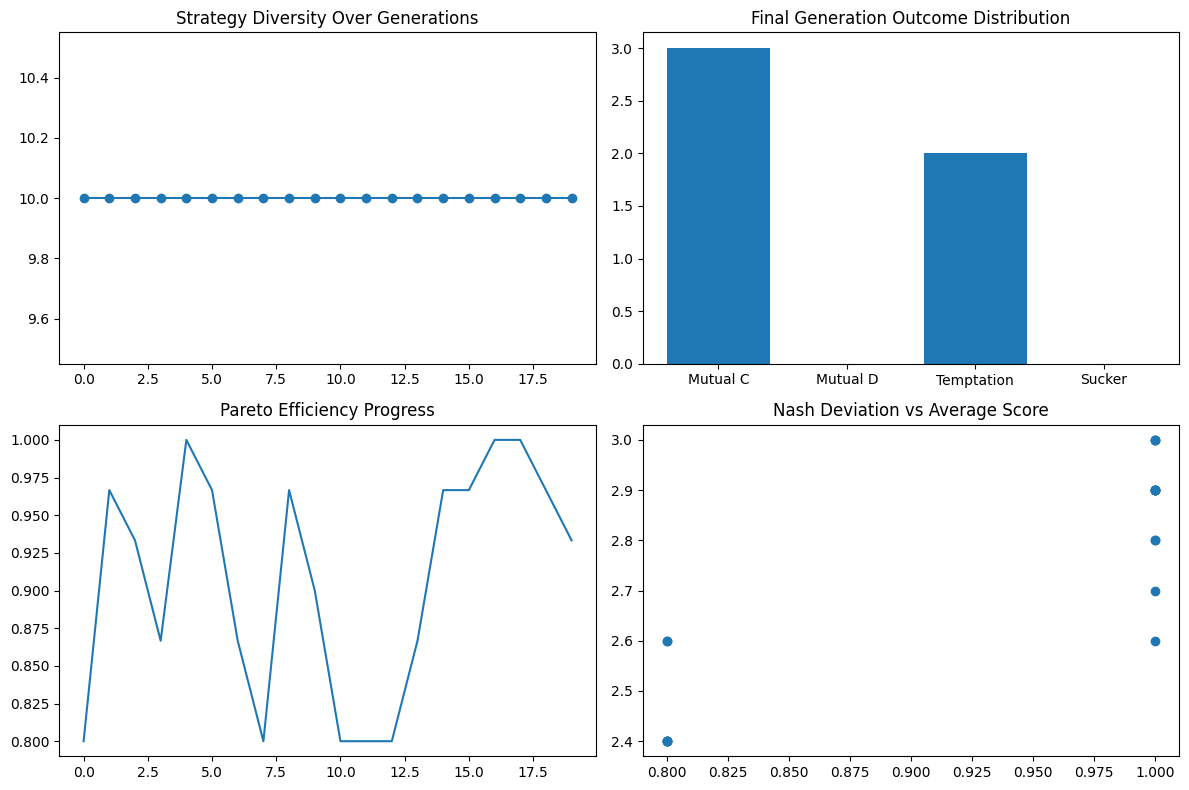

In [13]:
#%%
# Setup for Jupyter notebook execution
if not os.getenv('JUPYTER_RUNNING_IN_SCRIPT'):
    try:
        import nest_asyncio
        nest_asyncio.apply()
        import asyncio
        # Create event loop and run simulation
        loop = asyncio.get_event_loop()
        summary, logs = loop.run_until_complete(run_simulation())
    except ImportError:
        print("Please install nest_asyncio: pip install nest_asyncio")
else:
    # For running as a script
    summary, logs = asyncio.run(run_llm_driven_simulation(num_agents=4, num_generations=10))


## Analysis and Visualization

After running the simulation, you can analyze the results using the returned data:

- `summary`: Contains generation-level statistics

- `logs`: Contains detailed interaction logs



Example analysis:

```python

import pandas as pd



# Convert to DataFrames for analysis

summary_df = pd.DataFrame(summary)

logs_df = pd.DataFrame(logs)



# Analyze cooperation rates

cooperation_rates = logs_df['Actions'].apply(lambda x: x.count('C') / len(x))

print(f"Average cooperation rate: {cooperation_rates.mean():.2%}")

```